In [1]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.integrate import nquad
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [3]:
s = Survey(l, b, ds, obs_time, survey_area=survey_area, n_sources=n_sources, cadence=0.035, efficiency=0.7)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, cadence = 0.035, survey_area=1.767144375, n_sources=87000000.0, efficiency=0.7)

In [4]:
t_es = np.logspace(-2, 1, 20) #hours

In [5]:
m = 1e-8
s.add_pbh(m)
diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/pbh.py:134: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)


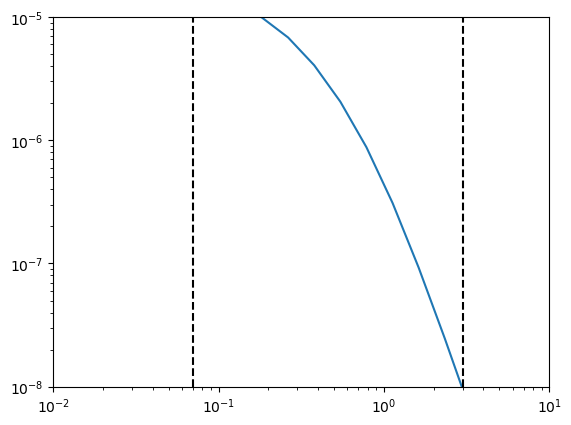

In [6]:
plt.loglog(t_es, np.array(diff_rates)*efficiency)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8,1e-5)
plt.show()

In [7]:
def get_n_events_point(m):
    ti = 0.07
    tf = 3
    s.add_pbh(m)
    # diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False, t_fwhm=True)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*dnds*s.obs_time*s.efficiency

def get_n_events_finite(m):
    s.add_pbh(m)
    # dnds = s.pbh.rate_tot(finite=True)
    # dnds = s.pbh.rate_tot_new(finite=True, t_fwhm=True)
    dnds = s.pbh.rate_tot_new(finite=True, t_fwhm=False)
    return s.n_sources*dnds*s.obs_time

def get_constraint_fdm(m, finite=False):
    if finite:
        n_events = get_n_events_finite(m)
    else:
        n_events = get_n_events_point(m)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1
    
def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [8]:
m_pbhs = np.logspace(-15, -4, 25) #solar masses

In [ ]:
fdms = get_constraint_fdm_parallel(m_pbhs, finite=False)

In [9]:
fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)

100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


In [10]:
# Define conversion factor
sol_to_gram = 1.989e33
m_grams = [x*sol_to_gram for x in m_pbhs]

In [11]:
data = [
    (3.9105064784322156e-12, 0.9038524945549944),
    (4.3729720246599206e-12, 0.4026039660255629),
    (5.268449819770012e-12, 0.0798801780801571),
    (5.676038171588299e-12, 0.03040372734940924),
    (1.030255599973466e-11, 0.011835067295194701),
    (1.611089774070761e-11, 0.005391471540435081),
    (2.338471271155493e-11, 0.0026273153012507018),
    (4.2445505996497985e-11, 0.0019183455070683109),
    (9.63426904595569e-11, 0.0019183455070683109),
    (2.0297538119362607e-10, 0.0021463834800823137),
    (7.761892749314231e-10, 0.0028743297195907447),
    (2.9681914475324916e-9, 0.0044045590729879375),
    (5.387553374677192e-9, 0.0052717064564509015),
    (1.774969678640442e-8, 0.005767340727442203),
    (3.470987698013668e-8, 0.006169413826439191),
    (6.787583892131858e-8, 0.006749448574119258),
    (1.278780827926779e-7, 0.008739033710674082),
    (2.409223122485026e-7, 0.01354276420828892),
    (5.468447886019586e-7, 0.02374705489017949),
    (9.213004737780419e-7, 0.0416401413540115),
    (0.0000014407082787888485, 0.06525805811569872),
    (0.000002252946138255002, 0.1144291271904097),
    (0.0000035231048343424115, 0.23481817441181593),
    (0.000005935574811543057, 0.4404559072987927),
    (0.00000861539275959552, 0.8641425016928873)
]

# Extract x and y values and convert them into NumPy arrays
x_values = np.array([item[0] for item in data])
y_values = np.array([item[1] for item in data])

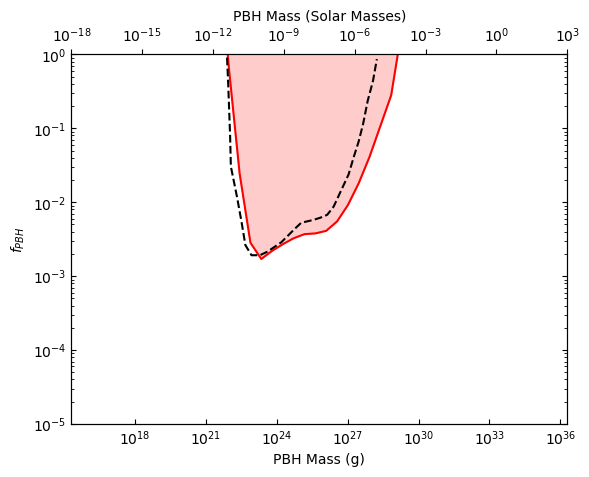

In [11]:
#FWHM Version
# Define conversion factor
sol_to_gram = 1.989e33

fig, ax2 = plt.subplots()

# Plot on first x-axis
# ax2.plot(m_grams, fdms, 'r', ls=':')
ax2.plot(m_grams, fdm_finite, 'r', ls='-')
ax2.fill_betweenx(fdm_finite, m_grams, color='r', alpha=0.2)  # shade the area above the curve
# ax2.fill_betweenx(fdms, [x*sol_to_gram for x in m_pbhs], color='r', alpha=0.2)  # shade the area above the curve

ax2.plot(x_values*sol_to_gram, y_values, 'k', ls='--')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('PBH Mass (g)')
ax2.set_ylabel(r'$f_{PBH}$')
ax2.set_ylim(1e-5, 1e0)
ax2.set_xlim([x*sol_to_gram for x in [1e-18, 1e3]])

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax1 = ax2.twiny()  # create a second x-axis

# Set the limits of the second x-axis
ax1.set_xlim(1e-18, 1e3)
ax1.set_xscale('log')
ax1.set_xlabel('PBH Mass (Solar Masses)')

plt.show()

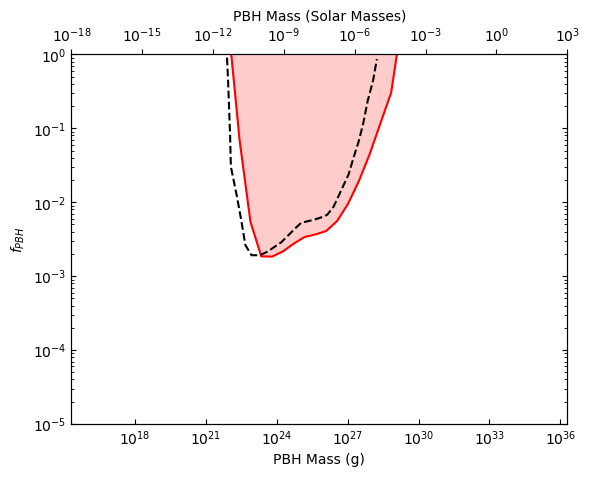

In [12]:
#t_DURATION VERSION
# Define conversion factor
sol_to_gram = 1.989e33

fig, ax2 = plt.subplots()

# Plot on first x-axis
# ax2.plot(m_grams, fdms, 'r', ls=':')
ax2.plot(m_grams, fdm_finite, 'r', ls='-')
ax2.fill_betweenx(fdm_finite, m_grams, color='r', alpha=0.2)  # shade the area above the curve
# ax2.fill_betweenx(fdms, [x*sol_to_gram for x in m_pbhs], color='r', alpha=0.2)  # shade the area above the curve

ax2.plot(x_values*sol_to_gram, y_values, 'k', ls='--')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('PBH Mass (g)')
ax2.set_ylabel(r'$f_{PBH}$')
ax2.set_ylim(1e-5, 1e0)
ax2.set_xlim([x*sol_to_gram for x in [1e-18, 1e3]])

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax1 = ax2.twiny()  # create a second x-axis

# Set the limits of the second x-axis
ax1.set_xlim(1e-18, 1e3)
ax1.set_xscale('log')
ax1.set_xlabel('PBH Mass (Solar Masses)')

plt.show()